In [40]:

# pip install numpy pandas
import numpy as np

import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Reshape,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import gc


In [16]:
 path_directory ="D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection"

#LIST ALL FILE IN THE DIRECTORY
files = os.listdir(path_directory)
print(files)
# Check for raw and augmented data
raw_data_path = os.path.join(path_directory, "Raw-Data")
augmented_data_path = os.path.join(path_directory, "CCMT Dataset-Augmented")

raw_data_path1 ="D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/Raw-Data/CCMT-Dataset"
crops_folder= os.listdir(raw_data_path1)
print(crops_folder)
 cashew_raw_data_path = os.path.join(raw_data_path1,"Cashew")
 tomatos_raw_data_path = os.path.join(raw_data_path1,"Tomato")
 Cassava_raw_data_path = os.path.join(raw_data_path1,"Cassava")
 Maize_raw_data_path = os.path.join(raw_data_path1,"Maize")
 print(cashew_raw_data_path)
print(tomatos_raw_data_path)

# print(cashew_raw_data_path)
# cashew_raw_dataFile = os.listdir(cashew_raw_data_path)
# print(cashew_raw_dataFile)
# anthracnose_path = os.path.join(cashew_raw_data_path, "anthracnose")


['CCMT Dataset-Augmented', 'Raw-Data']
['Cashew', 'Cassava', 'Maize', 'Tomato', 'Tomato.zip']
D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/Raw-Data/CCMT-Dataset\Cashew
D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/Raw-Data/CCMT-Dataset\Tomato


### Different Types of Crop's Show below

22


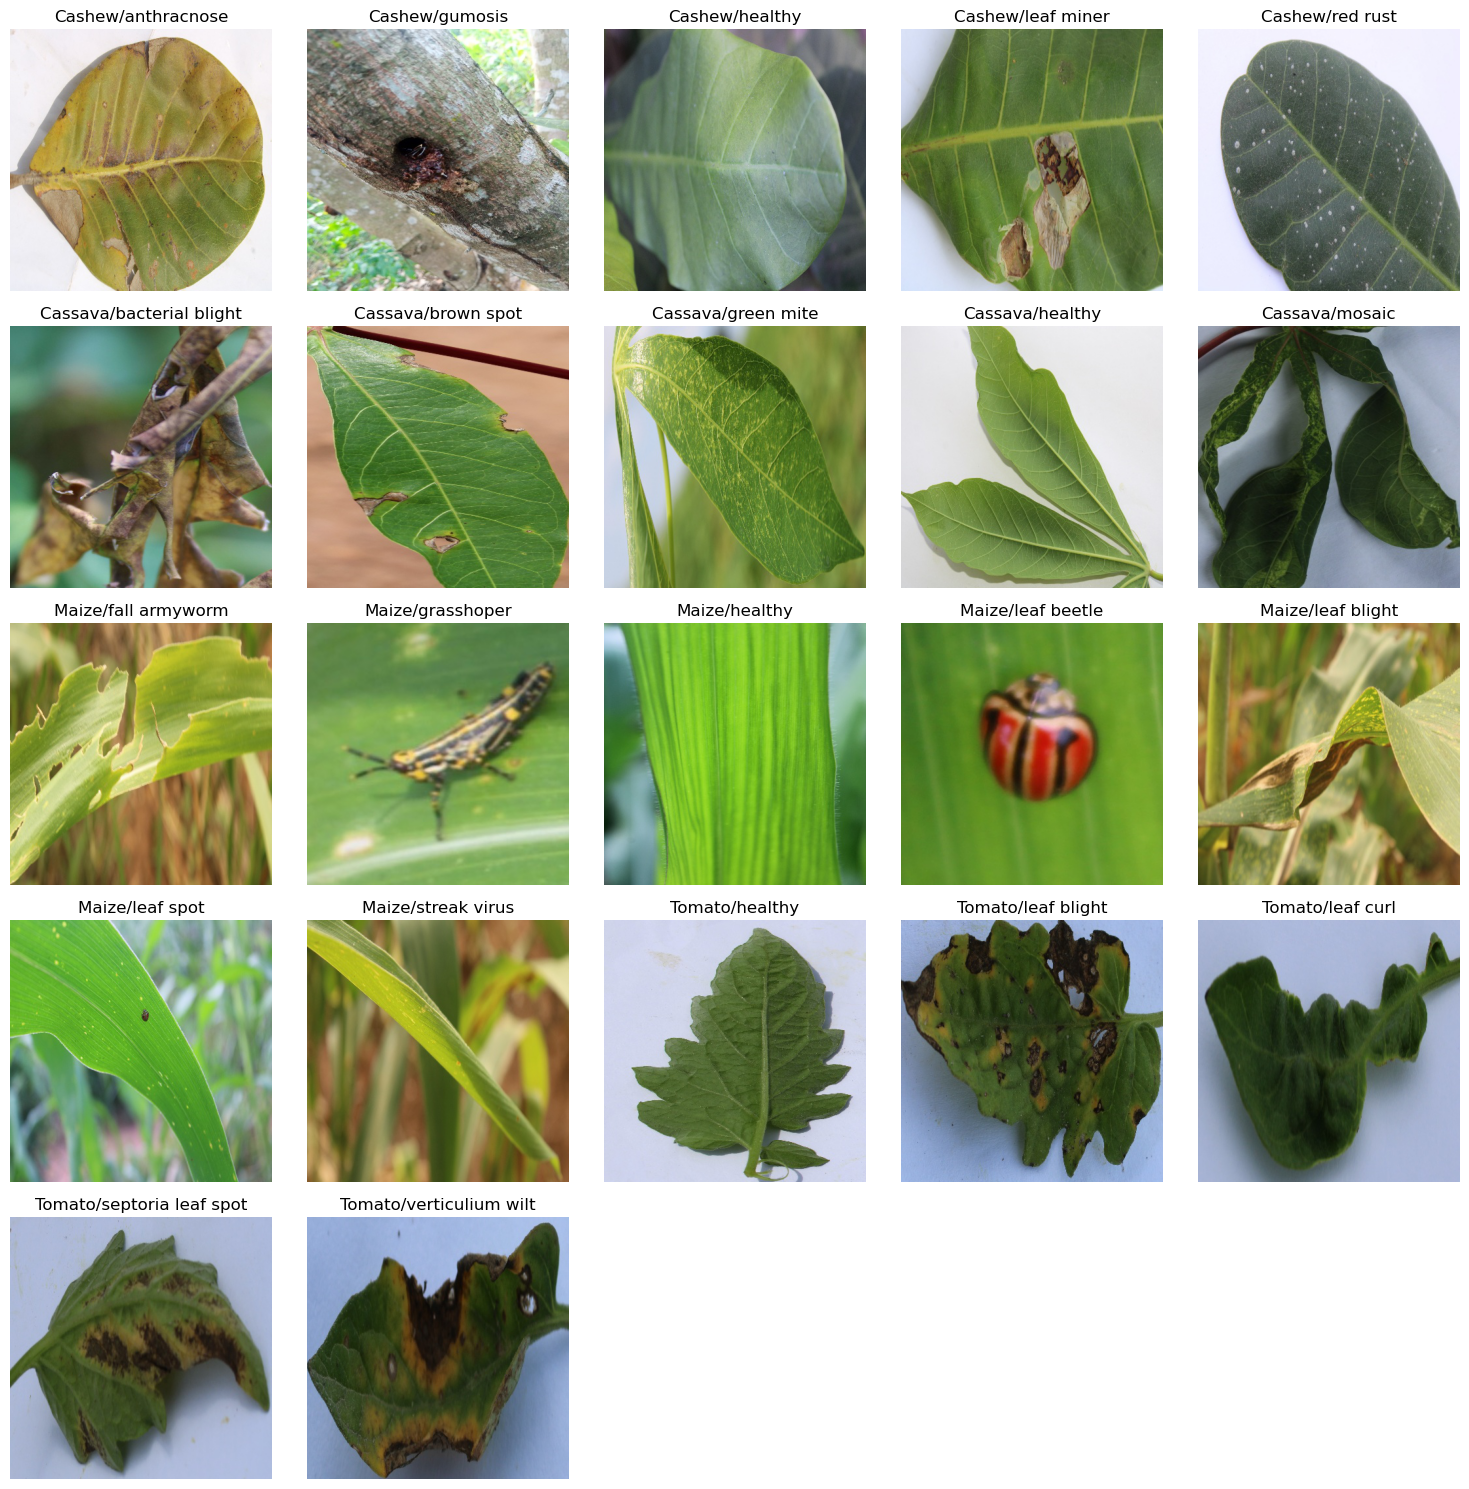

In [18]:
# Function to display images
def show_images_from_folders(base_dir, crop_folders, num_images=5):
     images_to_display = []  # Store images and titles for display
    # plt.figure(figsize=(15, 15))
    # image_count = 1
    
        # Traverse each crop folder
     for crop in crop_folders:
            crop_path = os.path.join(base_dir, crop)
            
            # Check for subfolders (disease/pest categories)
            if os.path.isdir(crop_path):
                for subfolder in os.listdir(crop_path):
                    subfolder_path = os.path.join(crop_path, subfolder)
                    
                    # Ensure it's a directory
                    if os.path.isdir(subfolder_path):
                        # Get all image files in the subfolder
                        images = [f for f in os.listdir(subfolder_path) if f.endswith(('.jpg'))]
                        
                        # Display a few images from each subfolder
                        for img_file in images[:num_images]:
                            img_path = os.path.join(subfolder_path, img_file)
                            try:
                                img = Image.open(img_path)
                                images_to_display.append((img, f"{crop}/{subfolder}"))
                            except Exception as e:
                                print(f"Error loading {img_path}: {e}")

    # Calculate grid size dynamically
     total_images = len(images_to_display)
     print(total_images)
     cols = 5
     rows = -(-total_images // cols)  # Ceiling division for rows
     plt.figure(figsize=(15, rows * 3))                 
     
     for i, (img, title) in enumerate(images_to_display):
         plt.subplot(rows, cols, i + 1)
         plt.imshow(img)
         plt.axis('off')
         plt.title(title)
     plt.tight_layout()
     plt.show() 

# Call the function to display images
show_images_from_folders(raw_data_path1, crops_folder, num_images=1)

### PreProcessing The Images for Tomatos

In [28]:
def load_dataset(base_dir, crop_folders, target_size=(128, 128)):
    images = []
    labels = []
    for label, crop in enumerate(crop_folders):
        crop_path = os.path.join(base_dir, crop)
        print(crop_path)
        if os.path.isdir(crop_path):
            for img_file in os.listdir(crop_path):
                        img_path = os.path.join(crop_path, img_file)
                        if img_file.endswith(('.jpg')):
                            try:
                                img = Image.open(img_path).convert('RGB')
                                img = img.resize(target_size)
                                images.append(np.array(img))
                                labels.append(label)  # Assign numeric labels per crop folder
                            except Exception as e:
                                pass
                                
    return np.array(images), np.array(labels)


In [64]:
# Load data
base_dir = tomatos_raw_data_path
tomatos_dataFile = os.listdir(base_dir)
print(tomatos_dataFile)
print(base_dir)
X, y = load_dataset(base_dir, tomatos_dataFile)
len(X)
len(y)

['healthy', 'leaf blight', 'leaf curl', 'septoria leaf spot', 'verticulium wilt']
D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/Raw-Data/CCMT-Dataset\Tomato
D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/Raw-Data/CCMT-Dataset\Tomato\healthy
D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/Raw-Data/CCMT-Dataset\Tomato\leaf blight
D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/Raw-Data/CCMT-Dataset\Tomato\leaf curl
D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/Raw-Data/CCMT-Dataset\Tomato\septoria leaf spot
D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/Raw-Data/CCMT-Dataset\Tomato\verticulium wilt


5780

In [89]:
train_path ="D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/CCMT Dataset-Augmented/Tomato/train_set/"
test_path = "D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/CCMT Dataset-Augmented/Tomato/test_set/"

In [91]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
         train_path,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=True)


Found 21723 images belonging to 5 classes.


In [93]:
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        shuffle=True)

Found 5445 images belonging to 5 classes.


In [95]:
# X = np.array(X)
# y = np.array(y)

# print(X.shape)
# if len(X.shape) == 3:
#     X = np.expand_dims(X, axis=-1)

# # y_one_hot = to_categorical(y)


# X_normalized =  X / 255.0




# # Convert labels to one-hot encoding
# y = to_categorical(y, num_classes= len(tomatos_dataFile))

# # Split into training and validation sets
# X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# print("Shape of X_train:", X_train.shape)
# print("Shape of y_train:", y_train.shape)
# print("Shape of X_test:", X_test.shape)
# print("Shape of y_test:", y_test.shape)



### Define CNN Architecture 

In [115]:
model = Sequential([
  Conv2D(32, (3, 3), activation='relu', input_shape=(150,150, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(32, (3, 3), activation='relu',input_shape=(150,150, 3)),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    # Dropout(0.5),
    
    Dense(5, activation='softmax')  # 5 categories
     # Reshape((5,5))
])

model.summary()



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,319,333 (20.29 MB)

 Trainable params: 5,319,333 (20.29 MB)

 Non-trainable params: 0 (0.00 B)

### Compile Model

In [117]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


### Fit the Model

In [103]:

# datagen = ImageDataGenerator(
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     zoom_range=0.3,
#     horizontal_flip=True,
#     rescale=1.0 / 255.0
# )
# datagen.fit(X_train)

In [119]:
history = model.fit(
    x=train_generator,
    validation_data=test_generator,
    epochs=32,
    # steps_per_epoch=len(train_generator) // 32,
    # verbose=1
)


Epoch 1/32
679/679 ━━━━━━━━━━━━━━━━━━━━ 428s 628ms/step - accuracy: 0.4271 - loss: 0.4615 - val_accuracy: 0.4911 - val_loss: 0.3915
Epoch 2/32
679/679 ━━━━━━━━━━━━━━━━━━━━ 260s 383ms/step - accuracy: 0.4992 - loss: 0.3921 - val_accuracy: 0.5550 - val_loss: 0.3615
Epoch 3/32
679/679 ━━━━━━━━━━━━━━━━━━━━ 265s 390ms/step - accuracy: 0.5402 - loss: 0.3701 - val_accuracy: 0.5388 - val_loss: 0.3617
Epoch 4/32
679/679 ━━━━━━━━━━━━━━━━━━━━ 420s 619ms/step - accuracy: 0.5682 - loss: 0.3515 - val_accuracy: 0.5969 - val_loss: 0.3331
Epoch 5/32
679/679 ━━━━━━━━━━━━━━━━━━━━ 292s 430ms/step - accuracy: 0.5813 - loss: 0.3427 - val_accuracy: 0.6165 - val_loss: 0.3249
Epoch 6/32
679/679 ━━━━━━━━━━━━━━━━━━━━ 260s 384ms/step - accuracy: 0.5923 - loss: 0.3363 - val_accuracy: 0.6228 - val_loss: 0.3187
Epoch 7/32
679/679 ━━━━━━━━━━━━━━━━━━━━ 262s 385ms/step - accuracy: 0.6088 - loss: 0.3285 - val_accuracy: 0.6187 - val_loss: 0.3182
Epoch 8/32
679/679 ━━━━━━━━━━━━━━━━━━━━ 261s 384ms/step - accuracy: 0.6144 -

### Scores is just a list containing loss and accuracy value

In [123]:
# Save the trained model to a file
model.save("CNN_TomatoModel.h5")

print("Model saved successfully as 'CNN_TomatoModel.h5'") 

Model saved successfully as 'CNN_TomatoModel.h5'


In [125]:
# Training loss and accuracy from the last epoch
training_loss = history.history['loss'][-1]  # Last epoch's training loss
training_accuracy = history.history['accuracy'][-1]  # Last epoch's training accuracy

print(f"Training Loss: {training_loss}")
print(f"Training Accuracy: {training_accuracy * 100:.4f}%")

test_loss, test_accuracy = model.evaluate(test_generator, batch_size=32)

print(f"Testing Loss: {test_loss}")
print(f"Testing Accuracy: {test_accuracy * 100:.4f}%")


Training Loss: 0.21772868931293488
Training Accuracy: 77.1210%
171/171 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.7836 - loss: 0.2143
Testing Loss: 0.21796061098575592
Testing Accuracy: 77.9247%


### Get Model Predictions

In [130]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)

# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes and class Labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  


# # Get model predictions for the test set
# predictions = model.predict(X_test)
# # Convert predictions to class indices
# predicted_classes = np.argmax(predictions, axis=1)
# predictedclasses_Flatend =  predicted_classes.reshape(-1)

# # Convert true labels to class indices (if one-hot encoded)
# true_classes = np.argmax(y_test, axis=1)
# trueClass_flatend =true_classes.reshape(-1)
# class_names = tomatos_dataFile

C:\Users\santo\AppData\Local\Temp\ipykernel_8324\3532209078.py:1: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)


171/171 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step


 ### Classification Report

In [138]:
# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_names)

print("Classification Report:")
print(report)

Classification Report:
                    precision    recall  f1-score   support

           healthy       0.09      0.09      0.09       500
       leaf blight       0.25      0.24      0.25      1309
         leaf curl       0.08      0.06      0.07       532
septoria leaf spot       0.43      0.50      0.46      2340
  verticulium wilt       0.14      0.10      0.12       764

          accuracy                           0.30      5445
         macro avg       0.20      0.20      0.20      5445
      weighted avg       0.28      0.30      0.29      5445



### Confusion Metrics

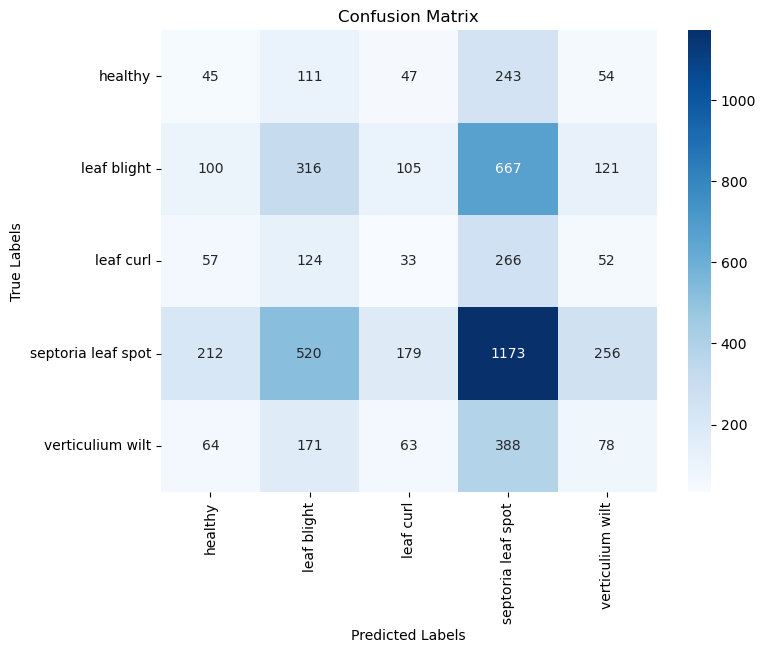

In [140]:
# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

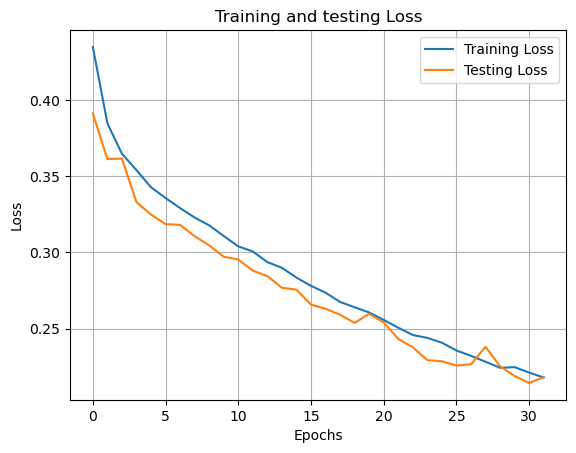

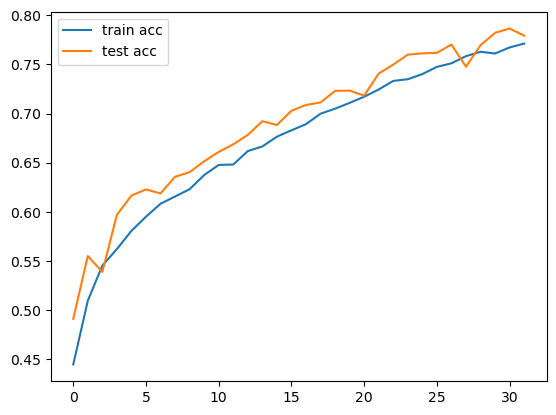

<Figure size 640x480 with 0 Axes>

In [144]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Training and testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='test acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

### InceptionsV3

In [146]:
# Load InceptionV3 without the top layer (to customize the output layer)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=[224,224,3])

In [148]:
# Freeze the base layers (InceptionV3) during initial training to only train the new top layers
for layer in base_model.layers:
    layer.trainable = False

In [152]:
from glob import glob
folder=glob("D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/CCMT Dataset-Augmented/Tomato/train_set/*")
print(folder)

['D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/CCMT Dataset-Augmented/Tomato/train_set\\healthy', 'D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/CCMT Dataset-Augmented/Tomato/train_set\\leaf blight', 'D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/CCMT Dataset-Augmented/Tomato/train_set\\leaf curl', 'D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/CCMT Dataset-Augmented/Tomato/train_set\\septoria leaf spot', 'D:/Master/Reseach/Dataset-for-Crop-Pest-and-Disease-Detection/CCMT Dataset-Augmented/Tomato/train_set\\verticulium wilt']


In [156]:
x=Flatten()(base_model.output)
predict_inception=Dense(units=len(folder),activation="softmax")(x)
inception_model=Model(inputs=base_model.input,outputs=predict_inception)


# # Add a Dense layer with 5 output units (for your 5 classes) and softmax activation
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)  # Dropout for regularization to prevent overfitting
# x = Dense(units=125,activation="softmax")(x)
# predict_inception = Reshape((5,5,5))(x)
# inception_model=Model(inputs=base_model.input,outputs=predict_inception)



### We have taken the optimizer Adam and the loss will be categorical crossentropy and our aim will be to find the accuracy

In [160]:
inception_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])




In [162]:
inception_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 111, 111,  │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 54, 54,    │      5,120 │ max_pooling2d_17… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,058,789 (84.15 MB)

 Trainable params: 256,005 (1000.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [164]:
# Data augmentation and preprocessing for the training and validation sets
train_datagen=ImageDataGenerator(rescale=1./255,
                                 horizontal_flip=True,rotation_range=.2,shear_range=.2)
test_datagen=ImageDataGenerator(rescale=1./255)


# Create training and testing data generators
training_set=train_datagen.flow_from_directory(train_path, target_size=(224,224),class_mode="categorical",batch_size=32,shuffle=True)
test_set=test_datagen.flow_from_directory(test_path,target_size=(224,224),class_mode="categorical",batch_size=32,shuffle=True)

# train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
# validation_generator = test_datagen.flow(X_val, y_val, batch_size=32)


Found 21723 images belonging to 5 classes.
Found 5445 images belonging to 5 classes.


In [168]:

transfer_inception=inception_model.fit(
                                       training_set,
                                       validation_data=test_set,
                                       validation_steps=len(test_set),
                                       steps_per_epoch=len(training_set),
                                       epochs=20)


C:\Users\santo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 869s 1s/step - accuracy: 0.4460 - loss: 4.8054 - val_accuracy: 0.5770 - val_loss: 4.0468
Epoch 2/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 852s 1s/step - accuracy: 0.5596 - loss: 3.6317 - val_accuracy: 0.6501 - val_loss: 2.9287
Epoch 3/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 850s 1s/step - accuracy: 0.5995 - loss: 3.3562 - val_accuracy: 0.5113 - val_loss: 4.3215
Epoch 4/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 846s 1s/step - accuracy: 0.6304 - loss: 3.1389 - val_accuracy: 0.6916 - val_loss: 2.3159
Epoch 5/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 837s 1s/step - accuracy: 0.6669 - loss: 2.7511 - val_accuracy: 0.6544 - val_loss: 2.6391
Epoch 6/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 10595s 16s/step - accuracy: 0.6578 - loss: 3.0256 - val_accuracy: 0.6893 - val_loss: 2.5212
Epoch 7/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 8800s 13s/step - accuracy: 0.6803 - loss: 2.8618 - val_accuracy: 0.6847 - val_loss: 2.7254
Epoch 8/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 1227s 2s/step - accuracy: 0.6956 - loss: 2.6668 - va

In [170]:
# Scores is just a list containing loss and accuracy value
scores=inception_model.evaluate(training_set)   
scores2=inception_model.evaluate(test_set)
print("Test Loss is :"+str(scores2[0]))
print("Test Accuracy is :"+str(scores2[1]*100)+" %")
print("Training Loss is :"+str(scores[0]))
print("Training Accuracy is :"+str(scores[1]*100)+" %")


679/679 ━━━━━━━━━━━━━━━━━━━━ 740s 1s/step - accuracy: 0.8266 - loss: 1.4527
171/171 ━━━━━━━━━━━━━━━━━━━━ 153s 893ms/step - accuracy: 0.7724 - loss: 2.6758
Test Loss is :2.717714309692383
Test Accuracy is :76.43709778785706 %
Training Loss is :1.415064811706543
Training Accuracy is :82.87989497184753 %


In [182]:
inception_model.save("inceptionv3_Tomato.h5")

In [172]:
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)
# Generate predictions
predictions = inception_model.predict(test_set, steps=test_steps_per_epoch)

# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes and class Labels
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())   


C:\Users\santo\AppData\Local\Temp\ipykernel_8324\888171397.py:1: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)


171/171 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step


In [174]:
#Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print("Classification Report:")
print(report)

Classification Report:
                    precision    recall  f1-score   support

           healthy       0.09      0.10      0.09       500
       leaf blight       0.22      0.16      0.19      1309
         leaf curl       0.10      0.08      0.09       532
septoria leaf spot       0.43      0.49      0.46      2340
  verticulium wilt       0.14      0.15      0.14       764

          accuracy                           0.29      5445
         macro avg       0.19      0.20      0.19      5445
      weighted avg       0.27      0.29      0.28      5445



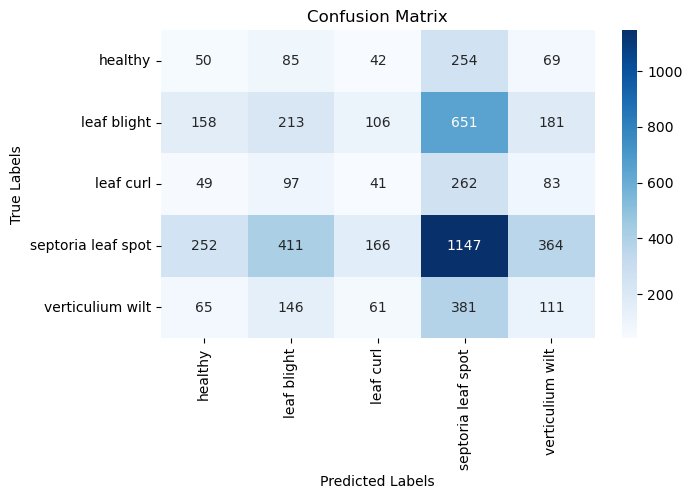

In [176]:

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(7, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

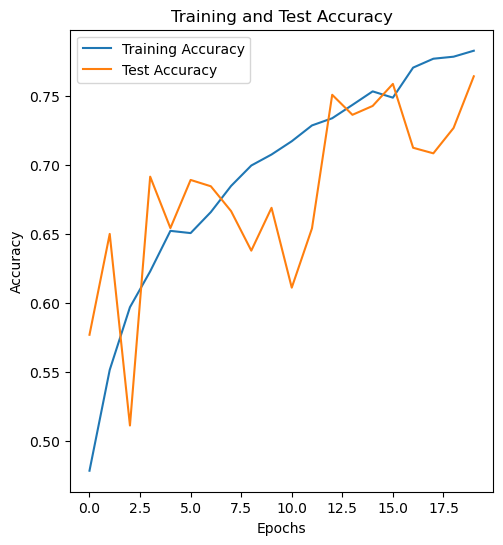

In [178]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(transfer_inception.history['accuracy'], label='Training Accuracy')
plt.plot(transfer_inception.history['val_accuracy'], label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()



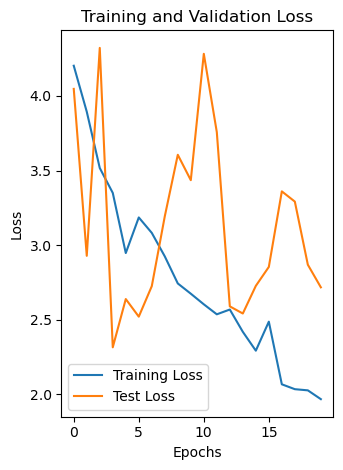

In [180]:
# Loss
plt.subplot(1, 2, 2)
plt.plot(transfer_inception.history['loss'], label='Training Loss')
plt.plot(transfer_inception.history['val_loss'], label='Test Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()